In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as sts

### Просмотр данных

In [2]:
df = pd.read_csv('analytics_test.csv')

In [3]:
df.head()

,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time
0,0,96422511,female,68,android,89656828,передачи о новых технологиях,show,share,6,playlist,0
1,1,45247030,male,62,android_tv,89784877,автопрому новости,news,search,0,NaN,0
2,2,79572413,male,12,web,10555855,логистическое законодательство,news,search,0,NaN,0
3,3,821317,female,58,android_tv,72054848,банковские премии новости,news,search,0,NaN,0
4,4,6206023,female,24,android,20838049,вики шоу аманда,show,subscribe,7,author,0


In [4]:
df.shape

(20000, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      20000 non-null  int64 
 1   user_id         20000 non-null  int64 
 2   sex             20000 non-null  object
 3   age             20000 non-null  int64 
 4   platform        20000 non-null  object
 5   query_id        20000 non-null  int64 
 6   query_text      20000 non-null  object
 7   query_type      20000 non-null  object
 8   event           20000 non-null  object
 9   click_position  20000 non-null  int64 
 10  doc_type        15042 non-null  object
 11  view_time       20000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.8+ MB


### Блок анализа платформ

In [6]:
platform_density = df.platform.value_counts(normalize=True) \
            .mul(100) \
            .round(2) \
            .reset_index() \
            .rename(columns={'proportion' : 'percentage'}) \
            .sort_values('percentage', ascending=False)
platform_density # колличество пользователей в процентном соотношении по платформам, заметно что браузером пользуется меньшее количество людей 

,platform,percentage
0,iphone,21.56
1,smart_tv,21.28
2,android,21.23
3,android_tv,19.92
4,web,16.01


Text(0.5, 1.0, 'Гистограмма процентов пользователей для платформ')

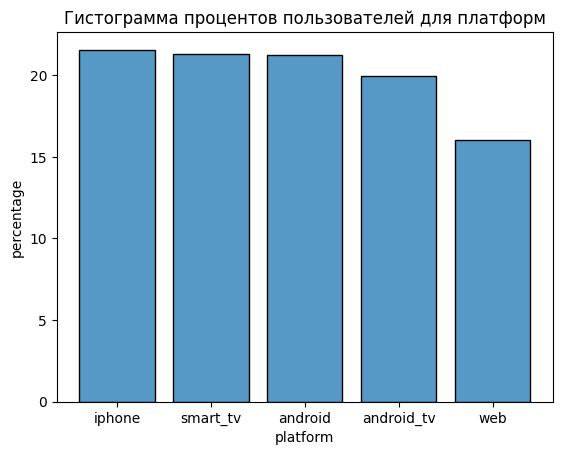

In [106]:
sns.histplot(data=platform_density, x='platform', binwidth=0.5 , weights='percentage', shrink=0.8)
plt.ylabel('percentage')
plt.title("Гистограмма процентов пользователей для платформ")

In [9]:
# возможно падение числа пользователей web связано с тем, что в браузерной верссии неудобный интерфейс, посмотрим на медиану click_position
df.groupby('platform', as_index=False).agg({'click_position': 'median'}).round(2) # различия есть но они не велеки

,platform,click_position
0,android,5.0
1,android_tv,3.0
2,iphone,5.0
3,smart_tv,3.0
4,web,6.0


In [11]:
# посмотрим сколько время тратят пользователи разных платформ на просмотр контента
# показатели различаются не сильно, скорее всего это связано с переходом людей на другие платформы
df[df['view_time'] > 0].groupby('platform', as_index=False).agg({'view_time' : 'mean'})

,platform,view_time
0,android,3056.155477
1,android_tv,5256.333333
2,iphone,3374.546099
3,smart_tv,5455.485876
4,web,3145.953995


In [12]:
# добавим столбец success, который будет отображать успешность клика
df['success'] = np.where(df['event'].isin(['search', 'tap']), 0, 1)

In [13]:
# в новостях процент успеха значительно ниже
all_query = df.success.count()
success_query = df[df['success'] == 1].groupby('query_type', as_index=False)['success'].count()
success_query['success'] = (success_query['success'] / all_query * 100).round(2)
success_query

,query_type,success
0,films,11.51
1,music,11.78
2,news,7.99
3,show,11.10


In [14]:
# посмотрим как быстро пользователи находят контент в случае успешного дествия
# наблюдаем что пользователи в среднем в более чем 2 раза дольше ищут новости, чаще всего на это уходит 14 документов в выдаче
query_click_median = df[df['success'] == 1].groupby('query_type', as_index=False).agg({'click_position': 'median'})
query_click_median

,query_type,click_position
0,films,3.0
1,music,8.0
2,news,14.0
3,show,6.0


C:\Users\den\AppData\Local\Temp\ipykernel_4336\2796484153.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df[df['success'] == 1], x='query_type', y = 'click_position', palette='viridis')


Text(0.5, 1.0, 'Гистограмма позиции клика для категорий запросов')

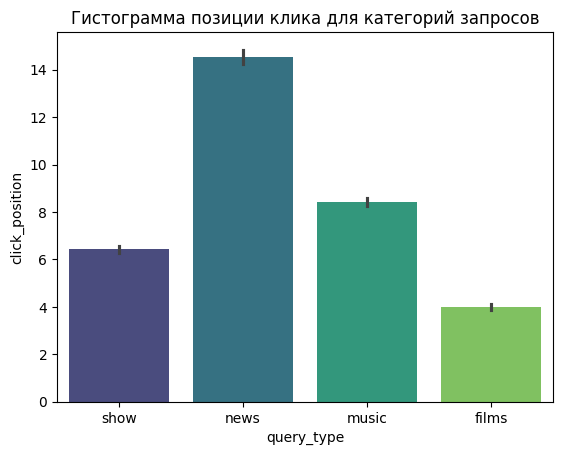

In [103]:
# на графике новости сильно отличаются от других категорий
sns.barplot(data = df[df['success'] == 1], x='query_type', y = 'click_position', palette='viridis')
plt.title("Гистограмма позиции клика для категорий запросов")

In [16]:
# посмотрим какому проценту пользователей приходится пролистывать более 15 документов что бы найти нужную новость
(df[(df['query_type'] == 'news') & (df['click_position'] > 15)]['user_id'].count() / df[(df['query_type'] == 'news')]['user_id'].count() * 100).round(2)

np.float64(34.24)

In [17]:
# посмотрим то же самое для других категрий, значения сильно отличаются, Получается больше трети пользователей сталкиваются с проблемой при поиске новостей
(df[(df['query_type'] != 'news') & (df['click_position'] > 15)]['user_id'].count() / df[(df['query_type'] == 'news')]['user_id'].count() * 100).round(2)

np.float64(5.36)

C:\Users\den\AppData\Local\Temp\ipykernel_4336\2746789558.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.query('query_type == "news"'), x='age', y = 'click_position', palette='viridis')


Text(0.5, 1.0, 'Гистограмма позиции клика для разного возраста для новостей')

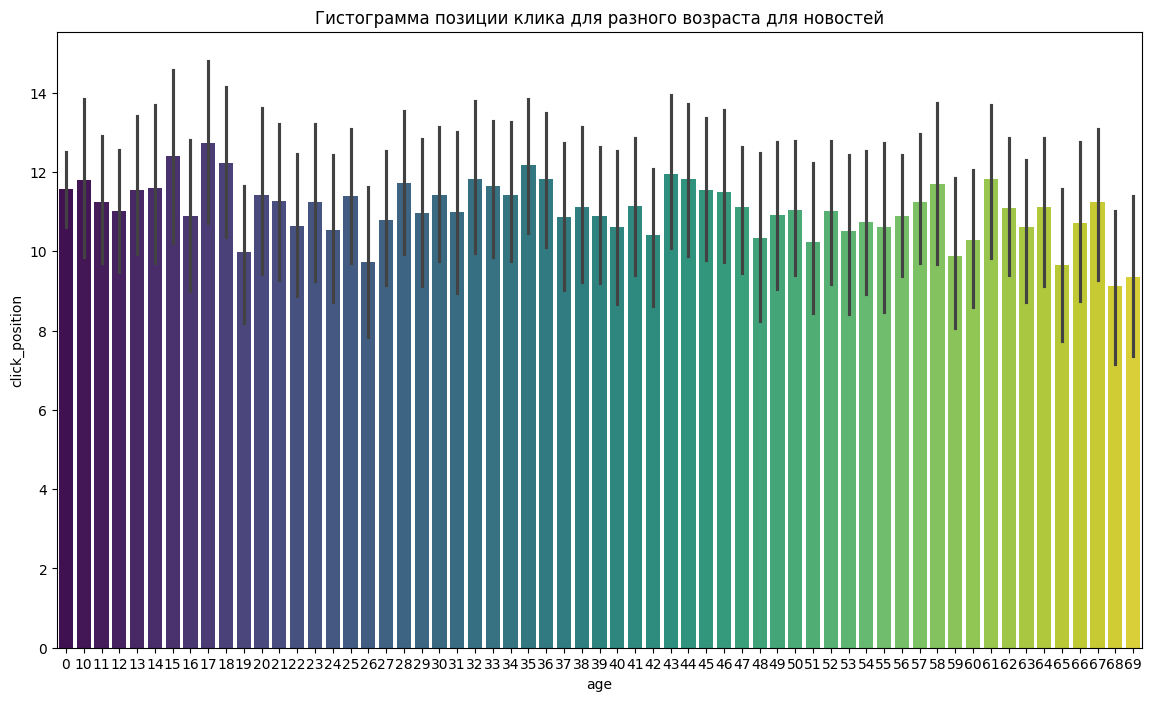

In [102]:
# проблема наблюдается для всех возрастов
plt.figure(figsize=(14,8))
sns.barplot(data=df.query('query_type == "news"'), x='age', y = 'click_position', palette='viridis')
plt.title("Гистограмма позиции клика для разного возраста для новостей")

C:\Users\den\AppData\Local\Temp\ipykernel_4336\3469993400.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.query('query_type == "news"'), x='sex', y = 'click_position', palette='viridis');


Text(0.5, 1.0, 'Гистограмма позиции клика для разных полов')

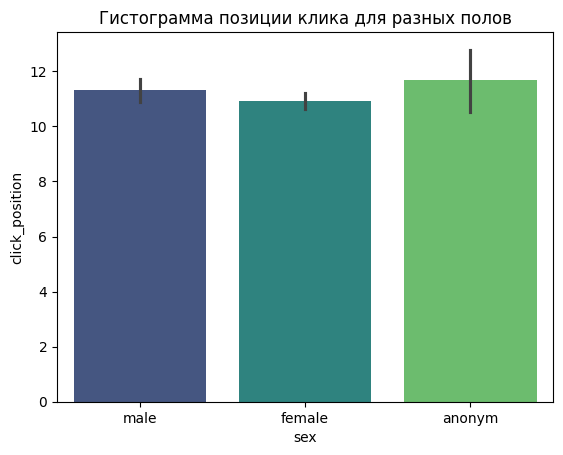

In [100]:
# проблема наблюдается для все полов
sns.barplot(data=df.query('query_type == "news"'), x='sex', y = 'click_position', palette='viridis');
plt.title("Гистограмма позиции клика для разных полов")

Text(0.5, 1.0, 'График времени просмотра к позиции клика для новостей')

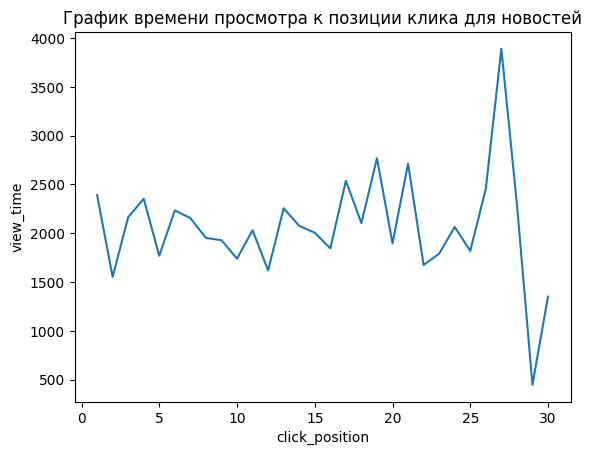

In [97]:
# видно что релевантный контент пользователи находят на больших кликах
sns.lineplot(data=df[df['view_time'] > 0].query('query_type == "news"'), x='click_position', y='view_time', 
             estimator=np.mean, errorbar=None)
plt.title("График времени просмотра к позиции клика для новостей")

In [21]:
# рассмотрим эти случаи 
# 6 и 3 больше походят на выбросы, а вот 735 новостей после 20 клика должны о чем то говорить
df[(df['click_position'] > 20)] \
    .groupby('query_type', as_index=False)['user_id'] \
    .count() \
    .rename(columns = {'user_id' : 'count_query'}) \
    .sort_values('count_query', ascending = False) 

,query_type,count_query
1,news,735
0,music,6
2,show,3


In [22]:
# посмотрим какую долю составляют эти клики, 14,7 процентов это довольно много, относительно других категорий
(df[(df['click_position'] > 20) & (df['query_type'] == 'news')]['user_id'].count() / df[df['query_type'] == 'news']['user_id'].count()) * 100

np.float64(14.7)

In [23]:
# процент успешного действия высокий, что еще раз говорит о том что пользователям приходится долго листать новоти что бы найти релевантный контент
news_critical = df[(df['click_position'] > 20) & (df['query_type'] == 'news')]
news_critical[news_critical['success'] == 1]['user_id'].count() / news_critical.shape[0] * 100

np.float64(41.76870748299319)

In [24]:
# посмотрим на то же самое но теперь для новостей с кликом менее 20, процент успешного действия довольно сильно упал
news_norm = df[(df['click_position'] < 20) & (df['query_type'] == 'news')]
news_norm[news_norm['success'] == 1]['user_id'].count() / news_norm.shape[0] * 100

np.float64(29.700073152889537)

In [25]:
# обьяснит ли нам высокий процент успешного дествия резкий скачек времени просмотра на больших кликах
mean_crit = news_critical.view_time.mean()
mean_norm = news_norm.view_time.mean()
mean_crit, mean_norm
# средние довольно сильно различаются 

(np.float64(334.7265306122449), np.float64(242.8158985613265))

In [26]:
news_critical.view_time.describe(), news_norm.view_time.describe()

(count     735.000000
 mean      334.726531
 std      1077.029442
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max      7060.000000
 Name: view_time, dtype: float64,
 count    4101.000000
 mean      242.815899
 std       928.090520
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max      7140.000000
 Name: view_time, dtype: float64)

In [27]:
# проверим гипотезу что средние значения статистически не значимы с критическим уровнем значимости 0.05
p_val = sts.ttest_ind_from_stats(mean1=mean_norm, mean2=mean_crit, std1=928.090520, std2=1077.029442, nobs1=news_norm.shape[0], nobs2=news_critical.shape[0])[1]
if p_val < 0.05:
    print("Гипотезу о равенстве средних отвергаем")
else:
    print("Не можем отвергнуть гипотезу о равенстве средних")

Гипотезу о равенстве средних отвергаем


Анализ категорий показал что поиск новостей работает в среднем хуже чем поиск по остальным категриям, пользователи находят релевантный контент после 20 документа, смотрят его больше <br>
Возможно это связано с алгоритмом ранжирования новостей

In [28]:
# исключим новости из датасета, так как они будут влиять на показатели 
df_no_news = df[df['query_type'] != 'news']
df_no_news.head(5)

,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time,success
0,0,96422511,female,68,android,89656828,передачи о новых технологиях,show,share,6,playlist,0,1
4,4,6206023,female,24,android,20838049,вики шоу аманда,show,subscribe,7,author,0,1
5,5,8004249,anonym,0,android,19760211,как купить билеты на Грибов,music,tap,1,author,0,0
6,6,11617125,female,66,android_tv,59650610,5+1 шоу парень бедный,show,subscribe,8,video,0,1
7,7,79473329,anonym,0,smart_tv,569617620,биография Мэрилин Монро,films,tap,5,clip,0,0


C:\Users\den\AppData\Local\Temp\ipykernel_4336\3583241943.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_no_news[df_no_news['view_time'] > 0], x = 'platform', y = 'view_time', palette='viridis')


Text(0.5, 1.0, 'Гистограмма среднего времени просмотра для платформ')

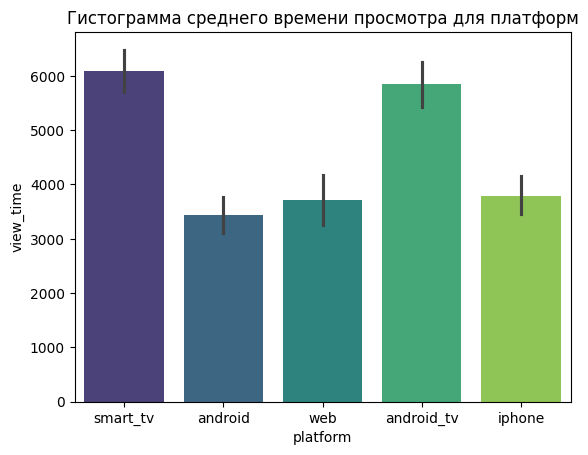

In [96]:
# посмотрим сколько времени в среднем люди тратят на просмотр контента на разных клатформах
sns.barplot(data=df_no_news[df_no_news['view_time'] > 0], x = 'platform', y = 'view_time', palette='viridis')
plt.title('Гистограмма среднего времени просмотра для платформ')

In [30]:
# время просмотра на телевизорах в среднем больше чем на других платформах, проверим связано ли это с тем что на телефизорах чаще всего смотрят фильмы
df_no_news[df_no_news['query_type'] == 'films'].groupby('platform', as_index=False)['user_id'].count().sort_values('user_id', ascending=False).rename(columns = {'user_id' : 'count_films'})

,platform,count_films
3,smart_tv,2066
1,android_tv,1918
2,iphone,475
0,android,279
4,web,262


Text(0.5, 1.0, 'График времени просмотра к позиции клика для категорий запросов')

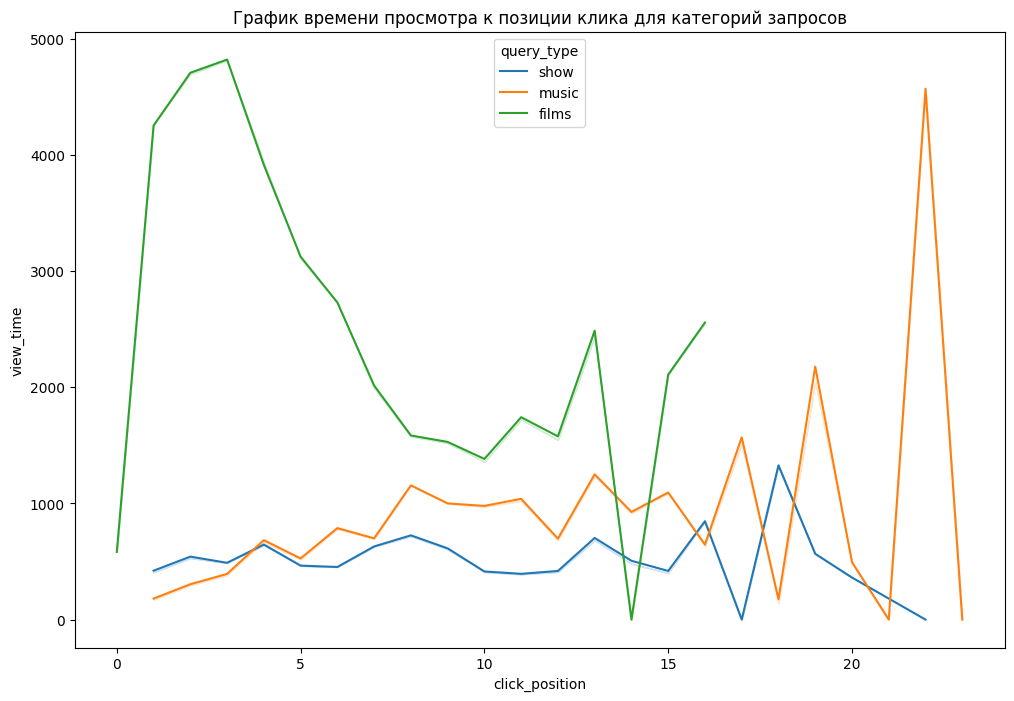

In [94]:
# посмотрим как распделится время по кликам, смотрим только успешные запросы
plt.figure(figsize=(12,8))
sns.lineplot(x='click_position', y='view_time', estimator=np.mean,
             data=df_no_news[(df_no_news['success']== 1) & (df_no_news['query_type'] != 'news')], 
             hue='query_type', errorbar=('ci', 0))
plt.title('График времени просмотра к позиции клика для категорий запросов')

Подробнее посмотрим на музыку

In [33]:
# видим что такой скачек обусловлен одним пользователем, он смотрел видео о музыке 2.5 часа, это точно выброс, посмотрим на все выбросы 
df_no_news[df_no_news['click_position'] > 20]

,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time,success
1152,1152,81917641,female,59,android,1499403,самые загружаемые треки,music,like,23,video,0,1
4636,4636,77602154,female,23,android_tv,4898871,микрофоны для студийного вокала,music,subscribe,22,video,0,1
6231,6231,10485556,female,32,android,74035402,шолшое шоу 11,show,tap,21,clip,0,0
6697,6697,93262124,female,26,iphone,69643141,обучение игре на укулеле,music,like,21,video,0,1
7734,7734,68791078,female,50,web,96966789,музыкальные чарты сегодня,music,subscribe,23,video,0,1
11292,11292,96180554,female,23,smart_tv,67174162,что сейчас слушают,music,subscribe,21,clip,0,1
11674,11674,36619373,female,39,smart_tv,32116798,Вик шоу попала в Страшный дом,show,tap,22,author,0,0
17113,17113,46134284,female,61,web,77488774,бльшое шоу 11 сезон,show,share,22,author,0,1
17166,17166,26205021,male,15,android,34174039,как создаются хиты,music,view,22,video,9139,1


C:\Users\den\AppData\Local\Temp\ipykernel_4336\905927558.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_news[df_no_news['view_time'] > 0], x = 'query_type' ,y = 'view_time', palette='viridis')


Text(0.5, 1.0, 'Ящик с усами для разных типов документов для категрий запросов')

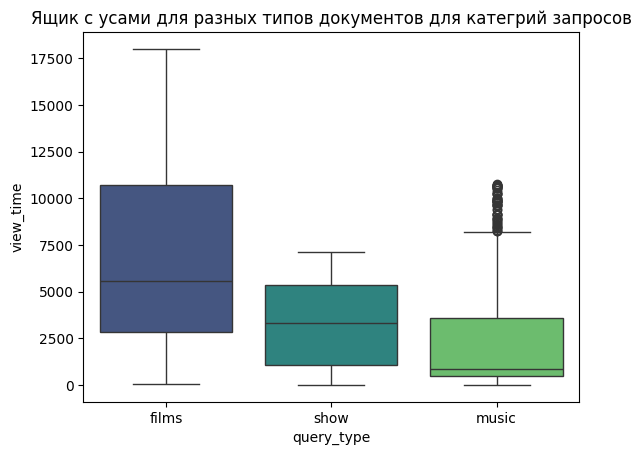

In [93]:
# видно что выбросов для музыки много, а для остальных категорий их и вовсе нет 
sns.boxplot(data=df_no_news[df_no_news['view_time'] > 0], x = 'query_type' ,y = 'view_time', palette='viridis')
plt.title('Ящик с усами для разных типов документов для категрий запросов')

C:\Users\den\AppData\Local\Temp\ipykernel_4336\1855545980.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_news[df_no_news['view_time'] > 0], x = 'doc_type' ,y = 'view_time', palette='viridis')


Text(0.5, 1.0, 'Ящик с усами для разных типов документов')

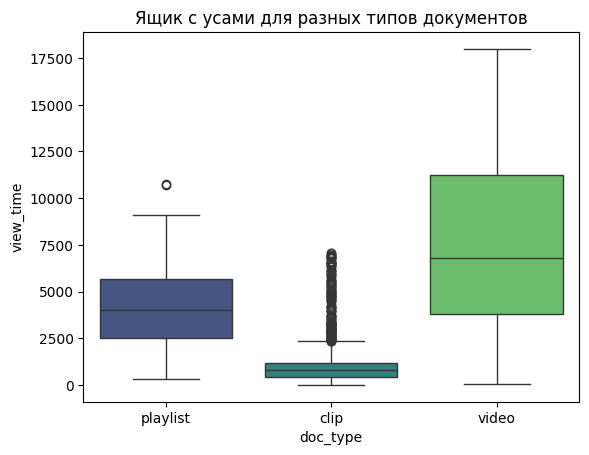

In [92]:
# посмотрим музыку но с разбивкой для типа документа, почти все выбросы для клипов, это нормально, так как пользователь может "залипнуть" и смореть дольше среднего, тут проблем нет 
sns.boxplot(data=df_no_news[df_no_news['view_time'] > 0], x = 'doc_type' ,y = 'view_time', palette='viridis')
plt.title("Ящик с усами для разных типов документов")

Text(0.5, 1.0, 'График времени просмотра к позиции клика для разных платформ ')

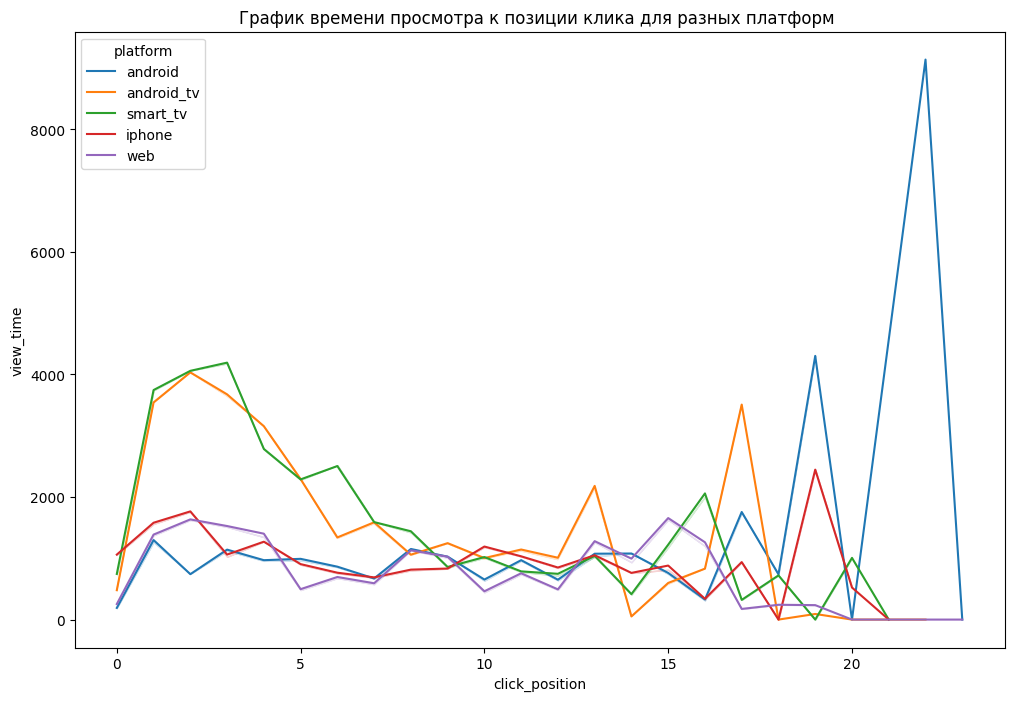

In [ ]:
# резкий скачек для android обусловлен пользователем который долго смотрел музыку 
plt.figure(figsize=(12,8))
sns.lineplot(x='click_position', y='view_time', estimator=np.mean, data=df_no_news[df_no_news['success']== 1], hue='platform', errorbar=('ci', 0))
plt.title("График времени просмотра к позиции клика для разных платформ")

In [ ]:
# один пользователь, который и создал скачек на графике
df_no_news[(df_no_news['click_position'] > 20) & (df_no_news['view_time'] > 0)]

,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time,success
17166,17166,26205021,male,15,android,34174039,как создаются хиты,music,view,22,video,9139,1


In [ ]:
# время просмотра для разных полов, есть странности для анонимных пользователей 
df[df['view_time'] > 0].groupby('sex', as_index=False).agg({'view_time' : 'mean'})

,sex,view_time
0,anonym,6318.741972
1,female,3033.574501
2,male,3816.759085


Text(0.5, 1.0, 'Категория запроса по отношению к среднему времени просмотра')

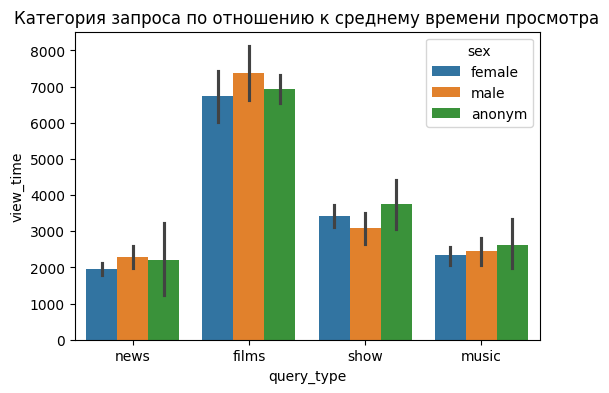

In [89]:
# на данном графике таких странностей нет, возможно анонимные пользователи чаще ищут фильмы нежели остальные категрии 
plt.figure(figsize=(6,4))
sns.barplot(data = df[df['view_time'] > 0], x='query_type', y='view_time', hue='sex', estimator=np.mean)
plt.title("Категория запроса по отношению к среднему времени просмотра")

In [ ]:
# посмотрим на средние клики для разных полов, получается странность, анонимные пользователи смотрят дольше и находят контент раньше
df[df['view_time'] > 0].groupby('sex', as_index=False).agg({'click_position' : 'median'})

,sex,click_position
0,anonym,4.0
1,female,9.0
2,male,8.0


In [ ]:
# посмотрим что чаще всего ищут анонимные пользователи
df.groupby(['query_type', 'sex'], as_index=False)['user_id'].count().sort_values('user_id', ascending=False).rename(columns={'user_id' : 'count'})

,query_type,sex,count
0,films,anonym,3278
7,news,female,3183
4,music,female,3048
10,show,female,2964
8,news,male,1611
11,show,male,1529
5,music,male,1464
1,films,female,880
2,films,male,842
9,show,anonym,507


странности для анонимных пользователей обьясняются тем, что они чаще ищут фильмы, соотвественно фильм легче найти и дольше смотреть

In [53]:
df_no_news[df_no_news['view_time'] > 0].groupby('doc_type', as_index=False).agg({'view_time' : 'mean'})

,doc_type,view_time
0,clip,1337.170524
1,playlist,4060.716792
2,video,7744.429373


In [53]:
# заметно что мужчины реже регистрируют аккаунты 
df.sex.value_counts(normalize=True) \
        .mul(100) \
        .round(2) \
        .reset_index() \
        .rename(columns={'proportion' : 'percentage'})

,sex,percentage
0,female,50.38
1,male,27.23
2,anonym,22.40


C:\Users\den\AppData\Local\Temp\ipykernel_4336\4018710860.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.sex.value_counts(normalize=True) \


Text(0.5, 1.0, 'Процентное соотношение пользователей поиска по половому признаку')

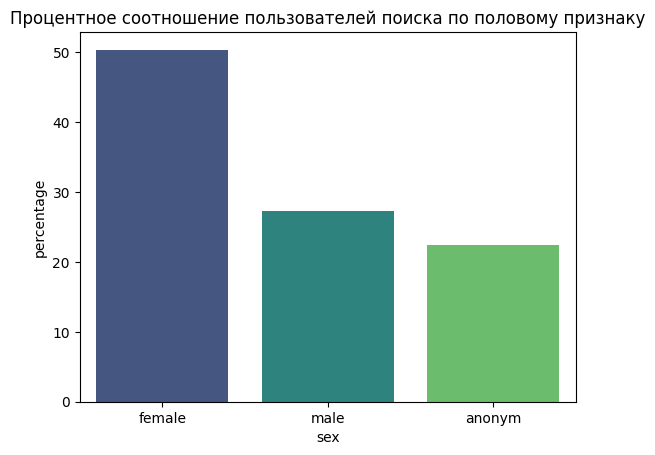

In [86]:
sns.barplot(data=df.sex.value_counts(normalize=True) \
                        .mul(100) \
                        .round(2) \
                        .reset_index() \
                        .rename(columns={'proportion' : 'percentage'}), x='sex', y = 'percentage', palette='viridis');
plt.title("Процентное соотношение пользователей поиска по половому признаку")

In [50]:
# время просмотра на кликах больше 15
df_no_news[(df_no_news['click_position'] > 15) & (df_no_news['view_time'] > 0)] \
            .groupby('query_type', as_index=False) \
            .agg({'view_time' : 'mean'})

,query_type,view_time
0,films,6392.500000
1,music,2687.976744
2,show,4003.500000


In [ ]:
# время просмотра на кликах меньше или равное 15, для запросов музыки и фильмов оно больше, 
# что говорит что пользователи находят релевантный контент за первые 15 новостей, для музыки меньше, но это обьяняется выбросами
df_no_news[(df_no_news['click_position'] <= 15) & (df_no_news['view_time'] > 0)] \
            .groupby('query_type', as_index=False) \
            .agg({'view_time' : 'mean'})

,query_type,view_time
0,films,6969.707339
1,music,2372.317105
2,show,3339.334294


In [60]:
# процент поисков которые ни к чему не привели, это похоже на хороший результат
# посмотрим что это за поиски
(df['event'] == 'search').mean().round(2) * 100


np.float64(25.0)

In [ ]:
# наблюдаем примерно одинаковое количество поисков которые ни к чему не привели
df[(df['event'] == 'search')] \
    .groupby('query_type', as_index=False)['user_id'] \
    .count() \
    .rename(columns = {'user_id' : 'count'})

,query_type,count
0,films,1258
1,music,1227
2,news,1232
3,show,1241


In [73]:
# посмотрев по половому признаку, видим что запросы от женщин чаще оказываются неудачными, посмотрим общее количество запросов для каждого пола
df[(df['event'] == 'search')] \
    .groupby('sex', as_index=False)['user_id'] \
    .count() \
    .rename(columns = {'user_id' : 'count'})

,sex,count
0,anonym,1114
1,female,2538
2,male,1306


In [79]:
# у женщин большее число запросов так как и пользователей женщин больше 
total_search = df.groupby('sex', as_index=False)['user_id'] \
    .count() \
    .rename(columns = {'user_id' : 'count'})
total_search

,sex,count
0,anonym,4479
1,female,10075
2,male,5446


In [80]:
# в процентном соотношении у всех примерно равное количество недачных запросов, 
unluck_search = df[(df['event'] == 'search')] \
    .groupby('sex', as_index=False)['user_id'] \
    .count() \
    .rename(columns = {'user_id' : 'count'}) 
res_search = pd.DataFrame()
res_search['sex'] = unluck_search['sex']
res_search['percentage'] = (unluck_search['count'] / total_search['count']).mul(100).round(2)
res_search

,sex,percentage
0,anonym,24.87
1,female,25.19
2,male,23.98


In [ ]:
# Проверим неудачные поиски по платформам, в целом ситуация равная, для web платформы меньше так как ей пользуются меньше людей 
df[(df['event'] == 'search')] \
    .groupby('platform', as_index=False)['user_id'] \
    .count() \
    .rename(columns = {'user_id' : 'count'})

,platform,count
0,android,1065
1,android_tv,997
2,iphone,1047
3,smart_tv,1062
4,web,787


### Подводя итоги, было замечено несколько слабых мест <br>
Высокий click_position для запросов типа новости, статистически пользователи дольше смотрят новости на высоких кликах и меньше на низких, возможно есть смысл пересмотреть алгортм ранжирования новостей <br>
Низкая конверсия для новостей, возможно показываются устаревшие новости, как решение добавить вкладку свежие новости<br>
Мужчины реже регистрируют аккаунт, что плохо для платформы, как путь решения акцентировать внимание на мужчинах, выявить потребности<br>